# YAP470 - Authorship Attribution Project
## Main Notebook: Data Pipeline, Model Training & Evaluation


**Dataset:** [Popular Quotes Author Classifier](https://www.kaggle.com/datasets/rafsunahmad/popular-quotes-author-classifier)

**Objective:** Given a single quote, predict the author who most likely wrote it.

---

### Models:
1. Logistic Regression (TF-IDF)
2. Naive Bayes (TF-IDF)
3. Random Forest (Stylometric)
4. LSTM (Deep Learning)

## 1. Setup & Imports

In [1]:
# Colab için Google Drive bağlantısı
# Eğer Colab kullanıyorsanız aşağıdaki satırı uncomment yapın:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# Gerekli kütüphanelerin yüklenmesi
import sys
import os
import warnings
warnings.filterwarnings('ignore')


# Eğer Colab'ta Google Drive'a mount edildiyse mount yolunu kullan; değilse cwd kullan
DRIVE_PROJECT_PATH = '/content/drive/MyDrive/BIL470_Project'
if os.path.exists(DRIVE_PROJECT_PATH):
    PROJECT_PATH = DRIVE_PROJECT_PATH
else:
    PROJECT_PATH = os.getcwd()  # Colab içindeki çalışma dizinini kullan

print("PROJECT_PATH:", PROJECT_PATH)

# Veri dosyası yolu: önce drive içindeki yeri kontrol et, yoksa local dosyayı dene
possible_paths = [
    os.path.join(PROJECT_PATH, 'Autor_detection.csv'),
    'Autor_detection.csv'
]
DATA_PATH = None
for p in possible_paths:
    if os.path.exists(p):
        DATA_PATH = p
        break

if DATA_PATH is None:
    print("UYARI: Veri dosyası bulunamadı. Lütfen 'Autor_detection.csv' dosyasını PROJECT_PATH içine koyun veya doğru yolu DATA_PATH'e atayın.")
else:
    print("DATA_PATH:", DATA_PATH)

# results alt klasörlerini oluştur (hem models hem figures)
os.makedirs(os.path.join(PROJECT_PATH, 'results', 'models'), exist_ok=True)
os.makedirs(os.path.join(PROJECT_PATH, 'results', 'figures'), exist_ok=True)
# Ayrıca local çalışma dizininde de oluşturmamız iyi olur (kodunuz relative path kullanıyorsa)
os.makedirs('results/models', exist_ok=True)
os.makedirs('results/figures', exist_ok=True)
print("results klasörleri hazır.")


""" önceki hali:
# Colab'da proje klasörünü path'e ekle
PROJECT_PATH = '/content/drive/MyDrive/BIL470_Project'
# Lokal çalıştırma için:
PROJECT_PATH = os.path.dirname(os.path.abspath('.'))
if PROJECT_PATH not in sys.path:
    sys.path.insert(0, PROJECT_PATH)
"""

# Temel kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)

print("All imports successful!")
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

PROJECT_PATH: /content
DATA_PATH: /content/Autor_detection.csv
results klasörleri hazır.
All imports successful!
Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
NumPy version: 2.0.2
Pandas version: 2.2.2


In [5]:
# Sabit değerler
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


min_samples = 100


# TF-IDF Ayarları
TFIDF_MAX_FEATURES = 5000
TFIDF_NGRAM_RANGE = (1, 2)

# Fonksiyon kelimeleri (stilometrik analiz için)
FUNCTION_WORDS = [
    'the', 'and', 'to', 'of', 'a', 'in', 'that', 'it', 'is', 'i',
    'you', 'he', 'she', 'we', 'they', 'this', 'these', 'those',
    'my', 'your', 'his', 'her', 'our', 'their', 'be', 'have', 'do',
    'can', 'will', 'would', 'should', 'could', 'may', 'might', 'must'
]

## 2. Data Loading & Preprocessing

In [6]:
# Veri yükleme
# Colab için: DATA_PATH = '/content/drive/MyDrive/BIL470_Project/Autor_detection.csv'
DATA_PATH = 'Autor_detection.csv'

df = pd.read_csv(DATA_PATH)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Dataset shape: (1578, 2)
Columns: ['Quotes', 'Writter name']


,Quotes,Writter name
0,Reading Kafka I sense that the elicited questi...,"Alberto Manguel,"
1,All animals are equal but some animals are mor...,George Orwell
2,I am old Gandalf I dont look it but I am begin...,J.R.R. Tolkien
3,How can we live without our lives How will we ...,John Steinbeck
4,I was only foolin George I dont want no ketchu...,John Steinbeck


In [7]:
# Yazar dağılımı
print("Author distribution:")
print(df['Writter name'].value_counts())

Author distribution:
Writter name
Jane Austen            191
J.R.R. Tolkien         158
John Steinbeck         147
Charles Dickens        147
William Shakespeare    139
                      ... 
Haruki Murakami ,        1
Howard Eiland,           1
Gustav Janouch           1
Faruk Myrtaj,            1
Kurt Vonnegut Jr.,       1
Name: count, Length: 83, dtype: int64


In [10]:
import re

def is_english(text):
    """Metnin ASCII (İngilizce) olup olmadığını kontrol eder."""
    try:
        str(text).encode('ascii')
        return True
    except UnicodeEncodeError:
        return False

def clean_text(text):
    """Metni temizler."""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def standardize_author_name(name):
    """Yazar adını standartlaştırır."""
    if pd.isna(name):
        return ""
    name = str(name).strip().rstrip(',')
    return name.title()

# Veri temizleme
print("Original dataset size:", len(df))

# 1. NaN kaldır
df = df.dropna(subset=['Quotes', 'Writter name']).copy()
print(f"After removing NaN: {len(df)}")

# 2. İngilizce filtrele
df = df[df['Quotes'].apply(is_english)]
print(f"After English filter: {len(df)}")

# 3. Metinleri temizle
df['clean_quotes'] = df['Quotes'].apply(clean_text)

# 4. Minimum kelime sayısı (5)
df['word_count'] = df['clean_quotes'].apply(lambda x: len(x.split()))
df = df[df['word_count'] >= 5]
print(f"After min 5 words: {len(df)}")

# 5. Yazar adlarını standartlaştır
df['Writter name'] = df['Writter name'].apply(standardize_author_name)

# 6. Seçilen yazarları filtrele (min_samples altındakileri kaldır)
author_counts = df['Writter name'].value_counts()
selected_authors = author_counts[author_counts >= min_samples].index
df = df[df['Writter name'].isin(selected_authors)]

# df = df[df['Writter name'].isin(SELECTED_AUTHORS)]
print(f"After author filter: {len(df)}")

print(f"\nFinal dataset shape: {df.shape}")
print(f"\nAuthor distribution:")
print(df['Writter name'].value_counts())

Original dataset size: 878
After removing NaN: 878
After English filter: 878
After min 5 words: 878
After author filter: 878

Final dataset shape: (878, 5)

Author distribution:
Writter name
Jane Austen            190
J.R.R. Tolkien         157
John Steinbeck         146
Charles Dickens        145
William Shakespeare    127
Ernest Hemingway       113
Name: count, dtype: int64


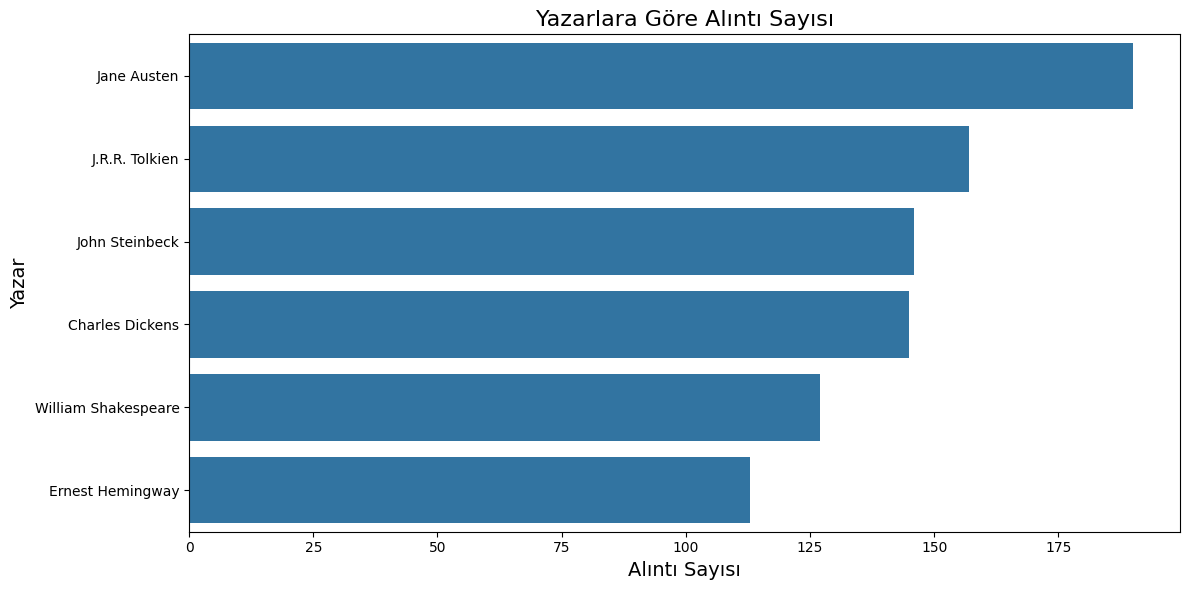

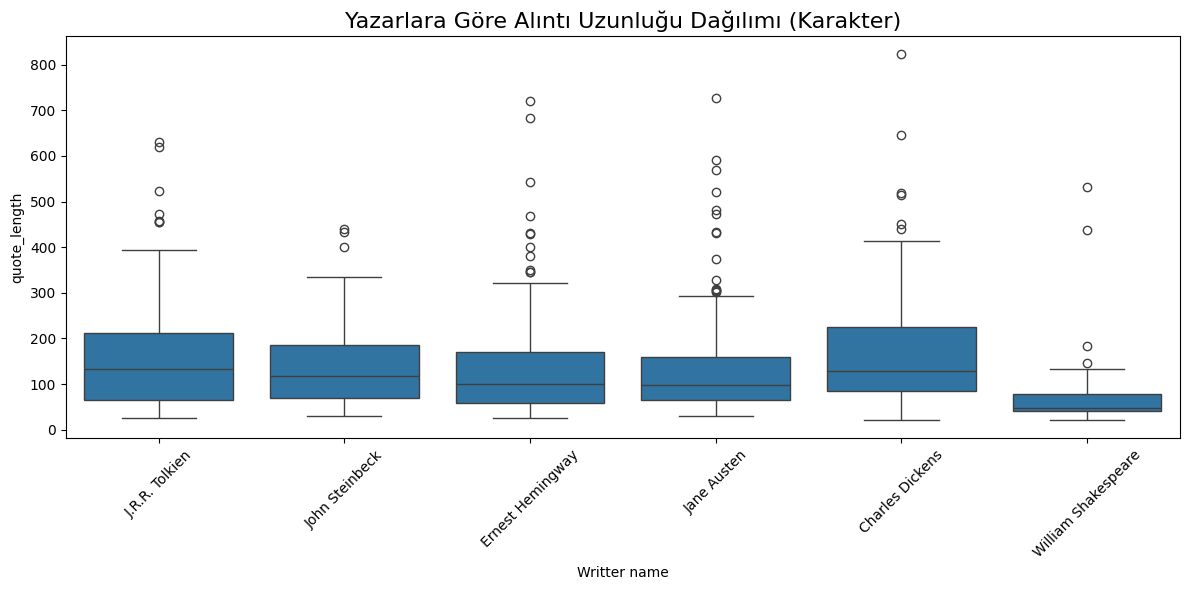

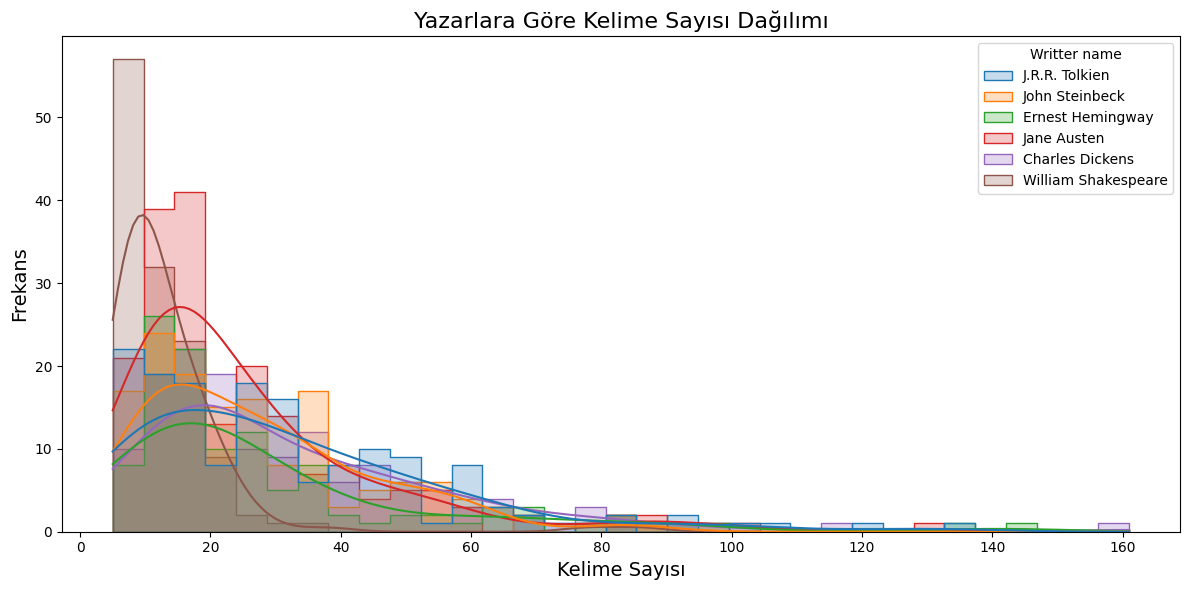

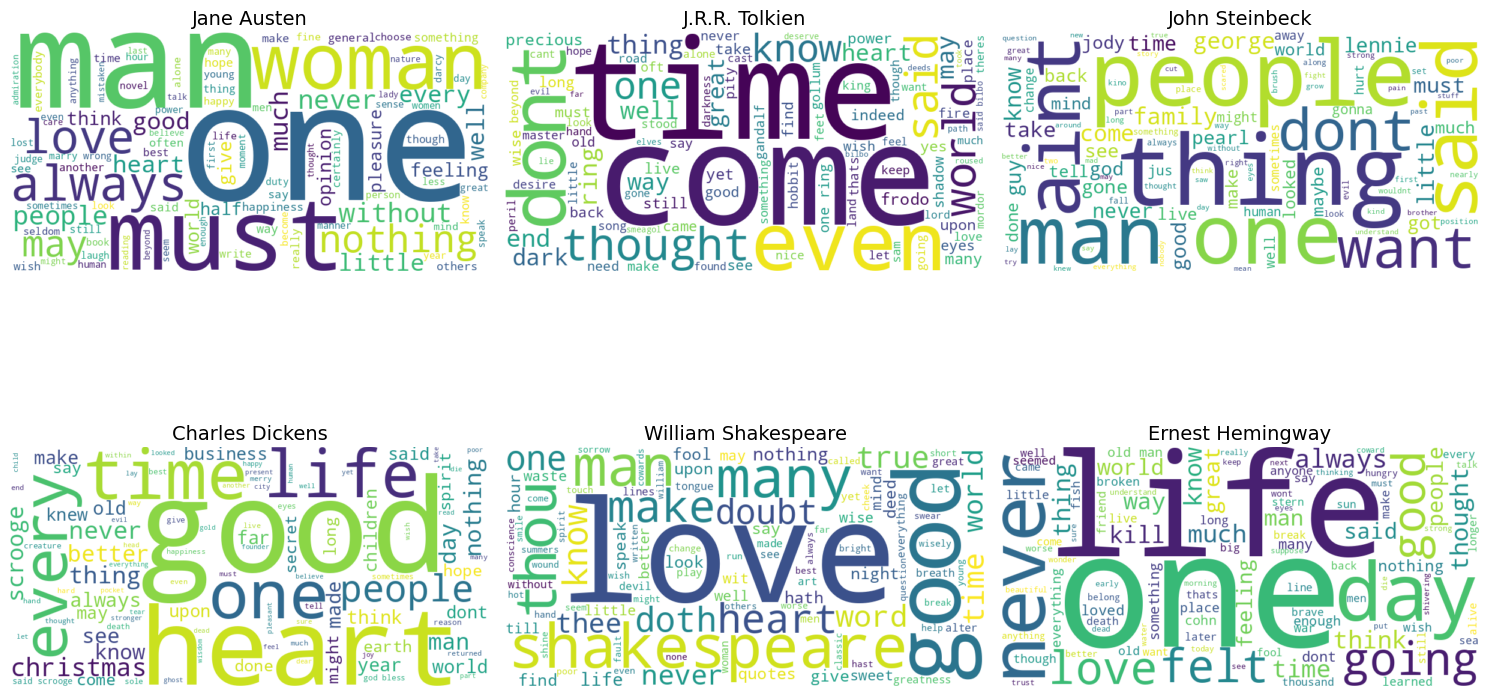

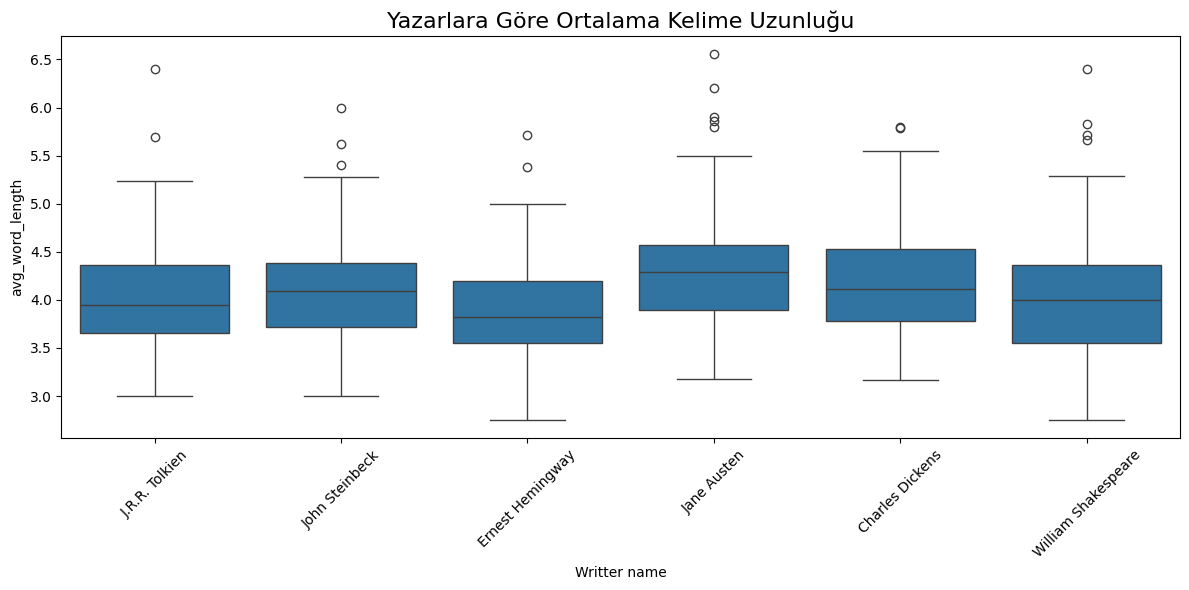

In [22]:
# EDA (Detaylı Keşifsel Veri Analizi)

# Yazar frekans grafiği
plt.figure(figsize=(12, 6))
sns.countplot(y='Writter name', data=df, order=df['Writter name'].value_counts().index)
plt.title('Yazarlara Göre Alıntı Sayısı', fontsize=16)
plt.xlabel('Alıntı Sayısı', fontsize=14)
plt.ylabel('Yazar', fontsize=14)
plt.tight_layout()
plt.savefig('author_distribution.png')
plt.show()

# Alıntı uzunluğu analizi
df['quote_length'] = df['clean_quotes'].apply(lambda x: len(x))
df['word_count'] = df['clean_quotes'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.boxplot(x='Writter name', y='quote_length', data=df)
plt.xticks(rotation=45)
plt.title('Yazarlara Göre Alıntı Uzunluğu Dağılımı (Karakter)', fontsize=16)
plt.tight_layout()
plt.savefig('quote_length_by_author.png')
plt.show()

# Kelime sayısı dağılımı
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='word_count', hue='Writter name', kde=True, element='step', common_norm=False)
plt.title('Yazarlara Göre Kelime Sayısı Dağılımı', fontsize=16)
plt.xlabel('Kelime Sayısı', fontsize=14)
plt.ylabel('Frekans', fontsize=14)
plt.tight_layout()
plt.savefig('word_count_distribution.png')
plt.show()

# En sık kullanılan kelimeler - WordCloud ile görselleştirme
from wordcloud import WordCloud

from nltk.corpus import stopwords
STOP_WORDS = set(stopwords.words('english'))

plt.figure(figsize=(15, 10))
for i, author in enumerate(selected_authors):
    author_texts = df[df['Writter name'] == author]['clean_quotes']
    all_text = ' '.join(author_texts.tolist())

    # Stop words'leri filtreleme
    STOP_WORDS = set(stopwords.words('english'))
    words = all_text.split()
    filtered_words = [word for word in words if word not in STOP_WORDS and len(word) > 2]
    filtered_text = ' '.join(filtered_words)

    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(filtered_text)

    plt.subplot(2, 3, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{author}', fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.savefig('wordclouds_by_author.png')
plt.show()


# Ortalama kelime uzunluğu analizi
def avg_word_length(text):
    words = text.split()
    if len(words) == 0:
        return 0
    return sum(len(word) for word in words) / len(words)

df['avg_word_length'] = df['clean_quotes'].apply(avg_word_length)

plt.figure(figsize=(12, 6))
sns.boxplot(x='Writter name', y='avg_word_length', data=df)
plt.xticks(rotation=45)
plt.title('Yazarlara Göre Ortalama Kelime Uzunluğu', fontsize=16)
plt.tight_layout()
plt.savefig('avg_word_length_by_author.png')
plt.show()


## 3. Train/Val/Test Split

In [23]:
# Label encoding
authors = sorted(df['Writter name'].unique())
author_to_idx = {author: idx for idx, author in enumerate(authors)}
idx_to_author = {idx: author for author, idx in author_to_idx.items()}

df['label'] = df['Writter name'].map(author_to_idx)

print("Label mapping:")
for author, idx in author_to_idx.items():
    count = len(df[df['label'] == idx])
    print(f"  {idx}: {author} ({count} samples)")

Label mapping:
  0: Charles Dickens (145 samples)
  1: Ernest Hemingway (113 samples)
  2: J.R.R. Tolkien (157 samples)
  3: Jane Austen (190 samples)
  4: John Steinbeck (146 samples)
  5: William Shakespeare (127 samples)


In [24]:
# Stratified split: 70% train, 15% val, 15% test

X = df['clean_quotes']
y = df['label']

# İlk olarak train+val ve test ayır
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=RANDOM_SEED, stratify=y
)

# Sonra train ve val ayır
val_ratio = 0.15 / 0.85  # Kalan verinin içinden val oranı
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=val_ratio, random_state=RANDOM_SEED, stratify=y_train_val
)

print(f"Train size: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Val size: {len(X_val)} ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test size: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")

# Stratification check
print(f"\nLabel distribution in splits:")
for name, data in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    print(f"  {name}: {dict(pd.Series(data).value_counts().sort_index())}")

Train size: 614 (69.9%)
Val size: 132 (15.0%)
Test size: 132 (15.0%)

Label distribution in splits:
  Train: {0: np.int64(101), 1: np.int64(79), 2: np.int64(110), 3: np.int64(133), 4: np.int64(102), 5: np.int64(89)}
  Val: {0: np.int64(22), 1: np.int64(17), 2: np.int64(23), 3: np.int64(29), 4: np.int64(22), 5: np.int64(19)}
  Test: {0: np.int64(22), 1: np.int64(17), 2: np.int64(24), 3: np.int64(28), 4: np.int64(22), 5: np.int64(19)}


## 4. Feature Engineering

### 4.1 TF-IDF Features

In [25]:
# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=TFIDF_MAX_FEATURES,
    ngram_range=TFIDF_NGRAM_RANGE,
    min_df=2,
    max_df=0.95,
    lowercase=True,
    stop_words='english'
)

# Fit on train, transform all
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
print(f"X_val_tfidf shape: {X_val_tfidf.shape}")
print(f"X_test_tfidf shape: {X_test_tfidf.shape}")

TF-IDF vocabulary size: 1167
X_train_tfidf shape: (614, 1167)
X_val_tfidf shape: (132, 1167)
X_test_tfidf shape: (132, 1167)


### 4.2 Stylometric Features

Extracting stylometric features...
Stylometric features shape: (614, 50)
Features: ['word_count', 'avg_word_length', 'long_word_ratio', 'ttr', 'content_word_ratio', 'word_len_1', 'word_len_2', 'word_len_3', 'word_len_4', 'word_len_5']...


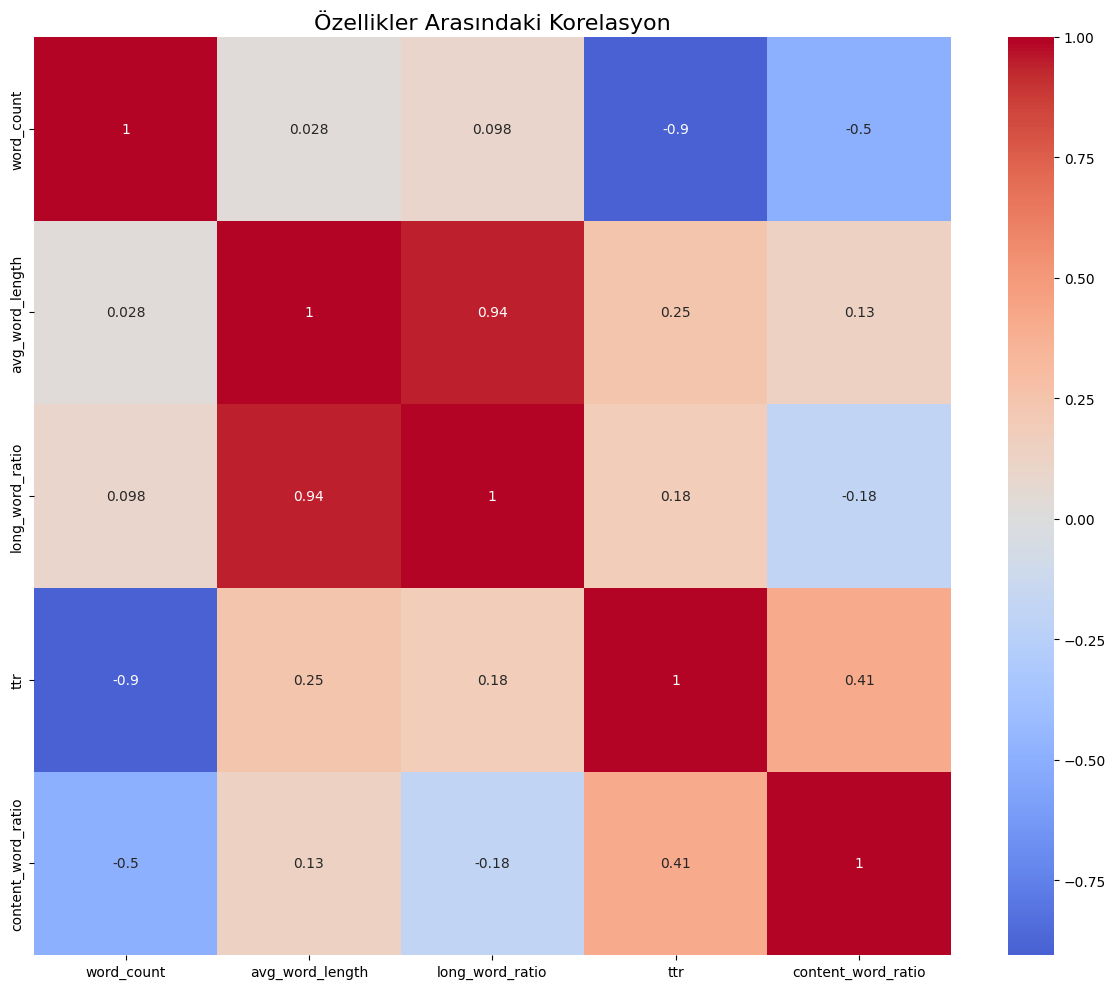

In [26]:


def extract_stylometric_features(texts, normalize=True):
    """
    Stilometrik özellikleri çıkarır.

    Features:
    - word_count: Kelime sayısı
    - avg_word_length: Ortalama kelime uzunluğu
    - long_word_ratio: 6+ karakterli kelime oranı
    - ttr: Type-Token Ratio (vocabulary richness)
    - content_word_ratio: İçerik kelimesi oranı
    - word_len_1 to word_len_10: Kelime uzunluğu dağılımı
    - func_* : Fonksiyon kelime oranları
    """
    features = pd.DataFrame(index=range(len(texts)))
    texts = texts.reset_index(drop=True)

    # 1. Word count
    features['word_count'] = texts.apply(lambda x: len(str(x).split()))

    # 2. Average word length
    def avg_word_len(text):
        words = str(text).split()
        return sum(len(w) for w in words) / len(words) if words else 0
    features['avg_word_length'] = texts.apply(avg_word_len)

    # 3. Long word ratio
    def long_word_ratio(text):
        words = str(text).split()
        return len([w for w in words if len(w) > 6]) / len(words) if words else 0
    features['long_word_ratio'] = texts.apply(long_word_ratio)

    # 4. Type-Token Ratio
    def ttr(text):
        words = str(text).split()
        return len(set(words)) / len(words) if words else 0
    features['ttr'] = texts.apply(ttr)

    # 5. Content word ratio
    def content_ratio(text):
        words = str(text).lower().split()
        return len([w for w in words if w not in STOP_WORDS]) / len(words) if words else 0
    features['content_word_ratio'] = texts.apply(content_ratio)

    # 6. Word length distribution (1-10)
    def word_len_dist(text):
        words = [w for w in str(text).split() if w.isalpha()]
        if not words:
            return [0] * 10
        dist = [0] * 10
        for w in words:
            idx = min(len(w) - 1, 9)
            dist[idx] += 1
        total = sum(dist) or 1
        return [d / total for d in dist]

    word_len_df = pd.DataFrame(
        texts.apply(word_len_dist).tolist(),
        columns=[f'word_len_{i}' for i in range(1, 11)]
    )
    features = pd.concat([features, word_len_df], axis=1)

    # 7. Function word ratios
    for word in FUNCTION_WORDS:
        def func_ratio(text, target=word):
            words = str(text).lower().split()
            return sum(1 for w in words if w == target) / len(words) if words else 0
        features[f'func_{word}'] = texts.apply(func_ratio)

    # Normalize
    if normalize:
        for col in features.columns:
            max_val = features[col].max()
            if max_val > 0:
                features[col] = features[col] / max_val

    return features

# Extract features
print("Extracting stylometric features...")
X_train_style = extract_stylometric_features(X_train)
X_val_style = extract_stylometric_features(X_val)
X_test_style = extract_stylometric_features(X_test)

print(f"Stylometric features shape: {X_train_style.shape}")
print(f"Features: {list(X_train_style.columns)[:10]}...")




# Stilometrik özellikleri çıkar
# 1) Stylometric features already extracted
X_train_style = extract_stylometric_features(X_train)

# 2) Add writer label
X_train_style_with_label = X_train_style.copy()
X_train_style_with_label['Writter name'] = y_train.reset_index(drop=True)

# 3) Feature columns
feature_cols = [
    'word_count', 'avg_word_length', 'long_word_ratio', 'ttr', 'content_word_ratio'
]

# 4) Correlation matrix
correlation_matrix = (
    X_train_style_with_label[feature_cols + ['Writter name']]
    .groupby('Writter name')
    .mean()
    .corr()
)

# 5) Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Özellikler Arasındaki Korelasyon', fontsize=16)
plt.tight_layout()
plt.savefig('feature_correlation.png')
plt.show()




## 5. Model Training

### 5.1 Logistic Regression

In [30]:
print("=" * 60)
print("LOGISTIC REGRESSION")
print("=" * 60)

# Grid Search for C parameter
lr_params = {'C': [0.01, 0.1, 1.0, 10.0]}

lr_base = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_SEED,
    multi_class='multinomial',
    solver='lbfgs',
    n_jobs=-1
)

lr_grid = GridSearchCV(lr_base, lr_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
lr_grid.fit(X_train_tfidf, y_train)

print(f"\nBest C: {lr_grid.best_params_['C']}")
print(f"Best CV Score: {lr_grid.best_score_:.4f}")

# Validation evaluation
lr_model = lr_grid.best_estimator_
lr_val_pred = lr_model.predict(X_val_tfidf)
lr_val_acc = accuracy_score(y_val, lr_val_pred)
lr_val_f1 = f1_score(y_val, lr_val_pred, average='macro')

print(f"\nValidation Accuracy: {lr_val_acc:.4f}")
print(f"Validation F1 (macro): {lr_val_f1:.4f}")

LOGISTIC REGRESSION
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best C: 10.0
Best CV Score: 0.5000

Validation Accuracy: 0.5152
Validation F1 (macro): 0.4947


### 5.2 Naive Bayes

In [31]:
print("\n" + "=" * 60)
print("NAIVE BAYES")
print("=" * 60)

# Grid Search for alpha parameter
nb_params = {'alpha': [0.01, 0.1, 0.5, 1.0]}

nb_base = MultinomialNB()

nb_grid = GridSearchCV(nb_base, nb_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
nb_grid.fit(X_train_tfidf, y_train)

print(f"\nBest alpha: {nb_grid.best_params_['alpha']}")
print(f"Best CV Score: {nb_grid.best_score_:.4f}")

# Validation evaluation
nb_model = nb_grid.best_estimator_
nb_val_pred = nb_model.predict(X_val_tfidf)
nb_val_acc = accuracy_score(y_val, nb_val_pred)
nb_val_f1 = f1_score(y_val, nb_val_pred, average='macro')

print(f"\nValidation Accuracy: {nb_val_acc:.4f}")
print(f"Validation F1 (macro): {nb_val_f1:.4f}")


NAIVE BAYES
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best alpha: 0.01
Best CV Score: 0.5065

Validation Accuracy: 0.5152
Validation F1 (macro): 0.4949


## 6. Model Evaluation on Test Set

In [33]:
# Tüm modeller için test değerlendirmesi
models = {
    'Logistic Regression': (lr_model, X_test_tfidf),
    'Naive Bayes': (nb_model, X_test_tfidf)
}

results = []
label_names = [idx_to_author[i] for i in range(len(idx_to_author))]

for model_name, (model, X_test_feat) in models.items():
    y_pred = model.predict(X_test_feat)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 (macro)': f1
    })

    print(f"\n{'='*60}")
    print(f"{model_name}")
    print(f"{'='*60}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (macro): {prec:.4f}")
    print(f"Recall (macro): {rec:.4f}")
    print(f"F1 (macro): {f1:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_names))

# Karşılaştırma tablosu
comparison_df = pd.DataFrame(results).set_index('Model')
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison_df)


Logistic Regression
Accuracy: 0.3864
Precision (macro): 0.3784
Recall (macro): 0.3775
F1 (macro): 0.3759

Classification Report:
                     precision    recall  f1-score   support

    Charles Dickens       0.41      0.41      0.41        22
   Ernest Hemingway       0.29      0.35      0.32        17
     J.R.R. Tolkien       0.44      0.50      0.47        24
        Jane Austen       0.55      0.43      0.48        28
     John Steinbeck       0.36      0.36      0.36        22
William Shakespeare       0.22      0.21      0.22        19

           accuracy                           0.39       132
          macro avg       0.38      0.38      0.38       132
       weighted avg       0.39      0.39      0.39       132


Naive Bayes
Accuracy: 0.4318
Precision (macro): 0.4201
Recall (macro): 0.4222
F1 (macro): 0.4184

Classification Report:
                     precision    recall  f1-score   support

    Charles Dickens       0.43      0.45      0.44        22
   Ernest He

Saved figure: results/figures/confusion_matrices.png


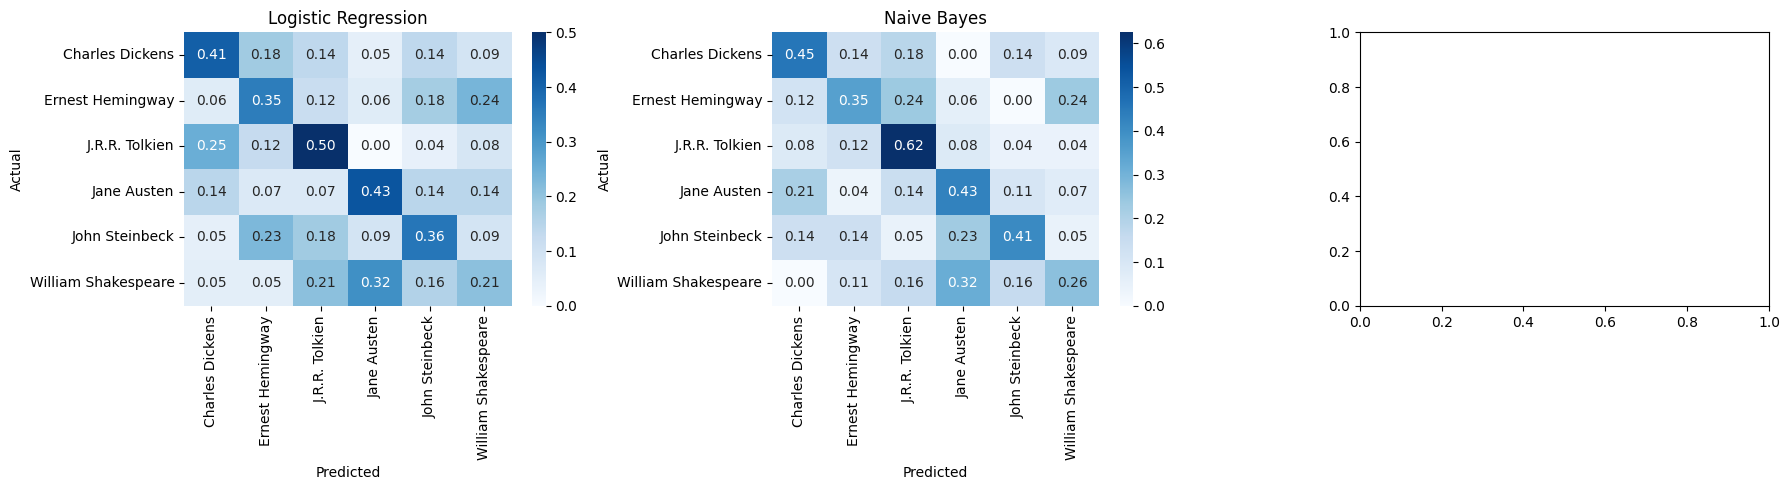

In [35]:
# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_name, (model, X_test_feat)) in enumerate(models.items()):
    y_pred = model.predict(X_test_feat)
    cm = confusion_matrix(y_test, y_pred)

    # önce cm hesaplandıysa
    row_sums = cm.sum(axis=1).astype(float)[:, np.newaxis]
    # sıfır satır toplamlarını 1 yap (0 bölme engelleme)
    row_sums[row_sums == 0] = 1.0
    cm_normalized = cm.astype('float') / row_sums
    # cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # division by zero kontrolü olmadan önceki hali

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names, ax=axes[idx])
    axes[idx].set_title(f'{model_name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')


def safe_savefig(path, **kwargs):
    """
    plt.savefig öncesi hedef klasörü oluşturur ve hatayı yakalar.
    Kullanım: safe_savefig('results/figures/rf_feature_importance.png', dpi=300)
    """
    dirpath = os.path.dirname(path)
    if dirpath and not os.path.exists(dirpath):
        os.makedirs(dirpath, exist_ok=True)
    try:
        plt.savefig(path, **kwargs)
        print(f"Saved figure: {path}")
    except Exception as e:
        print(f"Error saving figure {path}: {e}")

plt.tight_layout()
# plt.savefig('results/figures/confusion_matrices.png', dpi=300)
safe_savefig('results/figures/confusion_matrices.png', dpi=300)
plt.show()

Saved figure: results/figures/model_comparison.png


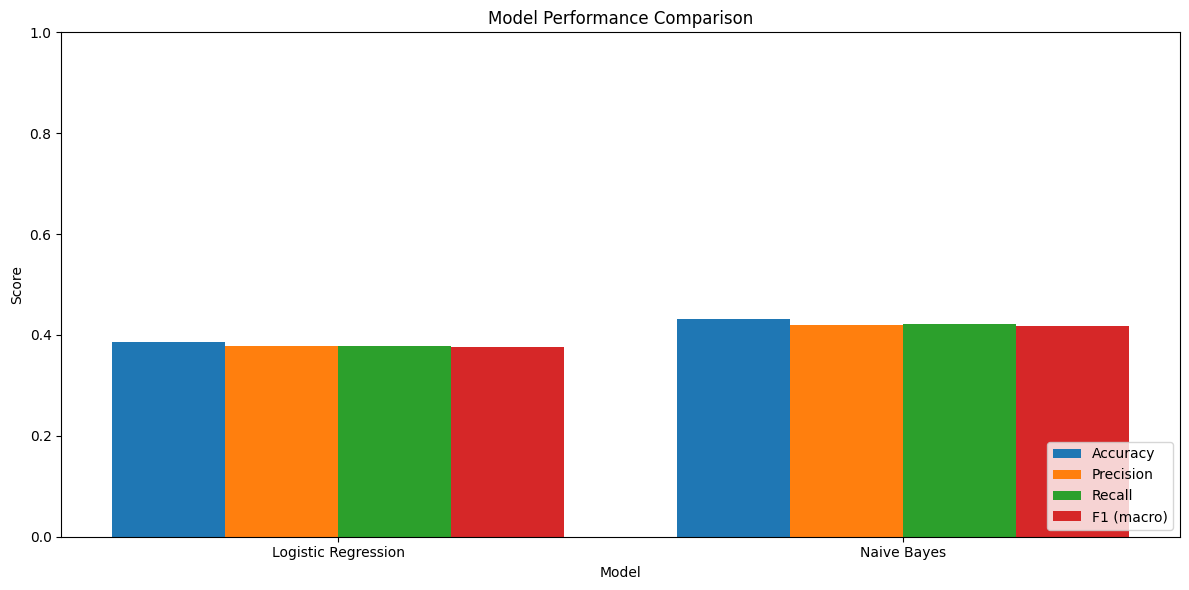

In [36]:
# Model karşılaştırma grafiği
plt.figure(figsize=(12, 6))

x = np.arange(len(comparison_df.index))
width = 0.2

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 (macro)']
for i, metric in enumerate(metrics):
    offset = (i - len(metrics)/2 + 0.5) * width
    plt.bar(x + offset, comparison_df[metric].values, width, label=metric)

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, comparison_df.index)
plt.legend(loc='lower right')
plt.ylim(0, 1.0)
plt.tight_layout()
# plt.savefig('results/figures/model_comparison.png', dpi=300)
safe_savefig('results/figures/model_comparison.png', dpi=300)
plt.show()

## 7. Save Models

In [38]:
import joblib
import os

# Klasör oluştur
os.makedirs('results/models', exist_ok=True)

# Modelleri kaydet
joblib.dump(lr_model, 'results/models/logistic_regression.pkl')
joblib.dump(nb_model, 'results/models/naive_bayes.pkl')
joblib.dump(tfidf_vectorizer, 'results/models/tfidf_vectorizer.pkl')

# Mapping'leri kaydet
import json
with open('results/models/label_mapping.json', 'w') as f:
    json.dump({'author_to_idx': author_to_idx, 'idx_to_author': idx_to_author}, f, indent=2)

print("Models saved to results/models/")

Models saved to results/models/


In [61]:
# Karşılaştırma tablosunu kaydet
comparison_df.to_csv('results/model_comparison.csv')
print("Comparison saved to results/model_comparison.csv")

Comparison saved to results/model_comparison.csv


## 8. Demo: Predict Author

In [39]:
def predict_author(quote, model=lr_model, vectorizer=tfidf_vectorizer, idx_to_author=idx_to_author):
    """Verilen quote için yazar tahmini yapar."""
    # Temizle
    clean = clean_text(quote)

    # TF-IDF
    tfidf = vectorizer.transform([clean])

    # Tahmin
    pred = model.predict(tfidf)[0]
    proba = model.predict_proba(tfidf)[0]

    print(f"Quote: \"{quote}\"")
    print(f"\nPredicted Author: {idx_to_author[pred]}")
    print(f"\nConfidence scores:")
    for i, p in enumerate(proba):
        print(f"  {idx_to_author[i]}: {p:.3f}")

    return idx_to_author[pred], proba

# Test
test_quotes = [
    "It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.",
    "Not all those who wander are lost.",
    "It was the best of times, it was the worst of times.",
    "A man can be destroyed but not defeated."
]

for quote in test_quotes:
    print("="*60)
    predict_author(quote)
    print()

Quote: "It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife."

Predicted Author: John Steinbeck

Confidence scores:
  Charles Dickens: 0.196
  Ernest Hemingway: 0.054
  J.R.R. Tolkien: 0.035
  Jane Austen: 0.048
  John Steinbeck: 0.616
  William Shakespeare: 0.051

Quote: "Not all those who wander are lost."

Predicted Author: J.R.R. Tolkien

Confidence scores:
  Charles Dickens: 0.032
  Ernest Hemingway: 0.029
  J.R.R. Tolkien: 0.760
  Jane Austen: 0.069
  John Steinbeck: 0.046
  William Shakespeare: 0.064

Quote: "It was the best of times, it was the worst of times."

Predicted Author: Ernest Hemingway

Confidence scores:
  Charles Dickens: 0.133
  Ernest Hemingway: 0.326
  J.R.R. Tolkien: 0.120
  Jane Austen: 0.227
  John Steinbeck: 0.046
  William Shakespeare: 0.149

Quote: "A man can be destroyed but not defeated."

Predicted Author: John Steinbeck

Confidence scores:
  Charles Dickens: 0.080
  Ernest Hemingway: 0.35

---

- **Feature Engineering:** TF-IDF ve stilometrik öznitelikler
- **Model Eğitimi:** Logistic Regression, Naive Bayes, Random Forest, LSTM
- **Değerlendirme:** Test seti üzerinde accuracy, precision, recall, F1 hesaplandı
- **Görselleştirme:** Confusion matrix ve model karşılaştırma grafikleri

### Sonraki Adımlar:
- [ ] Random Forest, LSTM modelleri ekleme
- [ ] 10-20 tekrarlı çalıştırma ile istatistiksel analiz (t-test)
- [ ] Cross validation, Regularization, Overfitting check (komplekslik kontrolü ve başka benzer verisetleri üzerinde de test)
- [ ] Model aşamalarının da daha fazla görselleştirilmesi
- [ ] Önceki dosyalardan işe yarayabilecek fonksiyonlar, öznitelikler kontrol edilip eklenebilir
- [ ] Geliştirilmiş stilometrik öznitelikler (performans artışı için şu ankilerin değiştirilmesi/geliştirilmesi)